In [ ]:
import torch
import torch.nn as nn
import torch.distributions as D

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

from tqdm import tqdm

In [ ]:
class HighDModel(nn.Module):
  def __init__(self, dim=60):
    super().__init__()
    self.dim = dim
    self.mu = 2
    self.sigma = nn.Parameter(torch.ones(self.dim) * 0.5, requires_grad=True)

  def sample(self, n_samples):
    z = torch.randn(n_samples, self.dim)

    return z * self.sigma + self.mu

  def forward(self, x, n_samples=1):
    """
    minMPJPE for x with n_samples.
    :param x:
    :param n_samples:
    :return:
    """
    samples = self.sample(n_samples)

    x = x.unsqueeze(0)
    s = samples.unsqueeze(-1).repeat(1, 1, x.size(-1))

    minMPJPE = torch.norm(x - s, dim=1).min(0).values
    return minMPJPE

## Grid search
We run a grid search across different number of samples and number of dimensions. For each set the $\sigma$ is optimized to minimize $\operatorname{minMPJPE}$

**Pretrained**
Running the grid search may take some time (approx. 25 mins) you may use instead our prerun data available under `./data/sigmas.npy`

In [ ]:
dims = torch.logspace(np.log10(1), np.log10(100), steps=20, base=10)
n_samples = torch.logspace(np.log10(1), np.log10(500), steps=20, base=10)
U, V = torch.meshgrid(dims, n_samples)

params = torch.stack((U, V), dim=-1)
params = params.reshape(-1, 2)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
sigmas = np.load('./data/sigmas.npy') # optional

In [ ]:
sigmas = torch.zeros(params.shape[0])

for j, (dim, n_samps) in tqdm(enumerate(params), total=len(dims) * len(n_samples)):
  x = torch.randn((dim.int().item(), 100)) * 0.5 + 2
  model = HighDModel(dim=dim.int().item())
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  for i in range(1000):
    optimizer.zero_grad()

    loss = model(x, n_samps.int().item()).mean() * n_samps
    loss.backward()

    optimizer.step()

  samples = model.sample(200)
  sigmas[j] = samples.std()

100%|██████████| 400/400 [25:48<00:00,  3.87s/it]


In [ ]:
# optionally you can overwrite the sigmas that we provide
# np.save('./data/sigmas.npy', sigmas.detach())

## Vizualization
We plot the optimal sigmas

In [ ]:
xticks = torch.logspace(np.log10(1), np.log10(100), steps=5, base=10)
xlabels = torch.linspace(0, 19, steps=5)

ylabels = torch.logspace(np.log10(1), np.log10(500), steps=5, base=10)

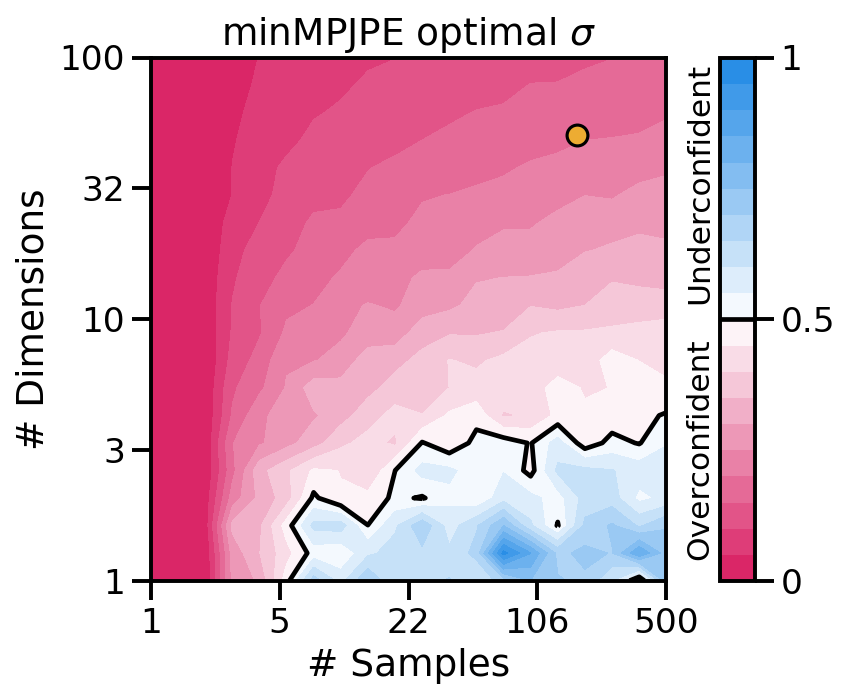

In [ ]:
cm = sns.blend_palette(['#D81B60', (1, 1, 1, 0), '#1E88E5'], as_cmap=True)
cm_k = sns.blend_palette([(0, 0, 0, 0), (0, 0, 0, 0)], as_cmap=True)

sns.set_context('talk')
plt.figure(figsize=(6, 5), dpi=150)
levels = np.linspace(0, 1, 21)
plt.contourf(sigmas.reshape(len(dims), len(n_samples)).detach(), vmin=0, vmax=1, cmap=cm, levels=levels)
plt.yticks(xlabels, xticks.round().int().numpy())
plt.xticks(xlabels, ylabels.round().int().numpy())

plt.xlabel('# Samples')
plt.ylabel('# Dimensions')
plt.title('minMPJPE optimal $\sigma$')


cbar = plt.colorbar(aspect=15, pad=0.08)
cbar.ax.set_axisbelow(True)
cbar.set_ticks([0, 0.5, 1])
cbar.ax.set_yticklabels([0, '0.5', '1'])
cbar.ax.text(-1, 0.05, 'Overconfident', fontsize=15, zorder=100, rotation=90)
cbar.ax.text(-1, 0.54, 'Underconfident', fontsize=15, zorder=100, rotation=90)

cbar.ax.axhline(0.5, c='k')
levels = [0.5]
line = plt.contour(sigmas.reshape(len(dims), len(n_samples)).detach(), cmap=cm_k, levels=levels)

plt.scatter(np.log(45) / np.log(100) * 19, np.log(200) / np.log(500) * 19, c='#EDAC32', marker='o', s=100, edgecolors='k')

plt.tight_layout()

plt.savefig('./minMPJPE_optimal_sigma.pdf')

plt.show()

## Pose Estimation Like Case

We optimize the case of 45 dimensions and 200 hypotheses and compare to the oracle model

In [ ]:
x = torch.randn((45, 100)) * 0.5 + 2
model = HighDModel(dim=45)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for i in range(1000):
  optimizer.zero_grad()

  loss = model(x, 200).mean() * 200
  loss.backward()

  optimizer.step()

In [ ]:
model(x, 200).mean()

tensor(3.0095, grad_fn=<MeanBackward0>)

**True model**
Test for the true model

In [ ]:
true_model = HighDModel(dim=45)
true_model(x, 200).mean()

tensor(3.4998, grad_fn=<MeanBackward0>)

In [ ]:
-D.Normal(model.mu, torch.abs(model.sigma)).log_prob(x.T).mean()

tensor(70.8613, grad_fn=<NegBackward0>)

In [ ]:
-D.Normal(true_model.mu, torch.abs(true_model.sigma)).log_prob(x.T).mean()

tensor(7.4349, grad_fn=<NegBackward0>)

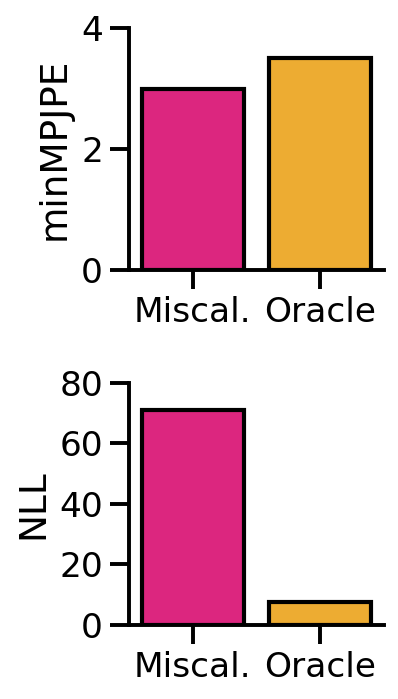

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(3, 5), dpi=150)
plt.subplot(2, 1, 1)
plt.bar([0, 1], [3.0, 3.5], edgecolor='k', lw=2, color=['#DC267F', '#EDAC32'])
plt.ylim(0, 4)
plt.xticks([0, 1], ['Miscal.', 'Oracle'])
plt.ylabel('minMPJPE')

plt.subplot(2, 1, 2)
plt.bar([0, 1], [70.86, 7.43], edgecolor='k', lw=2, color=['#DC267F', '#EDAC32'])
plt.xticks([0, 1], ['Miscal.', 'Oracle'])
plt.yticks([0, 20, 40, 60, 80], [0, 20, 40, 60, 80])
sns.despine()
plt.ylabel('NLL')

plt.xlim(-.5, 1.5)

plt.tight_layout()
plt.savefig('scores.pdf')